Processing note 1 
1/1 [==============================] - 5s 5s/step
Processing note 2 
1/1 [==============================] - 1s 687ms/step
Processing note 3 
1/1 [==============================] - 1s 543ms/step
Processing note 4 
1/1 [==============================] - 1s 586ms/step
Processing note 5 
1/1 [==============================] - 1s 725ms/step
Processing note 6 
1/1 [==============================] - 1s 763ms/step
Processing note 7 
1/1 [==============================] - 1s 700ms/step
Processing note 8 
1/1 [==============================] - 1s 769ms/step
Processing note 9 
1/1 [==============================] - 1s 787ms/step
Processing note 10 
1/1 [==============================] - 1s 771ms/step
Processing note 11 
1/1 [==============================] - 1s 766ms/step
Processing note 12 
1/1 [==============================] - 1s 690ms/step
Processing note 13 
1/1 [==============================] - 1s 831ms/step
Processing note 14 
1/1 [==============================] - 1s 7

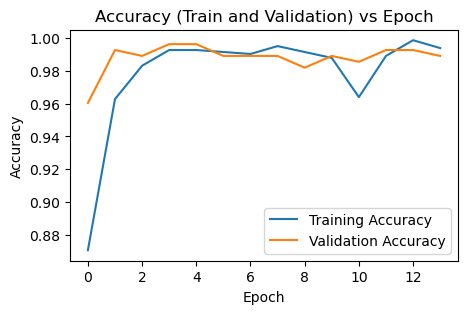

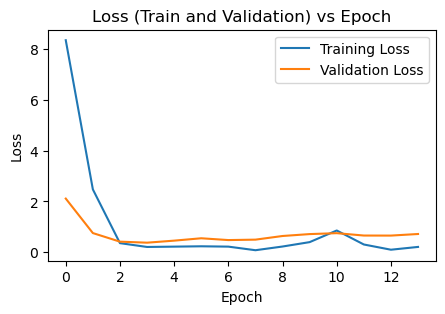

9/9 [==============================] - 3s 63ms/step - loss: 0.4684 - accuracy: 0.9892
Test loss: 0.46844398975372314
Test accuracy: 0.9892086386680603
9/9 [==============================] - 1s 57ms/step - loss: 0.3755 - accuracy: 0.9964
Validation loss: 0.3755326569080353
Validation accuracy: 0.9964028596878052
9/9 [==============================] - 1s 46ms/step

 Note Path | Predicted Label | Original Label 
---------------------------------------------
 E:/modified_dataset\fake_notes\note_135 | fake | fake
 E:/modified_dataset\fake_notes\note_029 | fake | fake
 E:/modified_dataset\fake_notes\note_317 | fake | fake
 E:/modified_dataset\real_notes\note_289 | real | real
 E:/modified_dataset\fake_notes\note_099 | fake | fake
 E:/modified_dataset\real_notes\note_559 | real | real
 E:/modified_dataset\fake_notes\note_463 | fake | fake
 E:/modified_dataset\fake_notes\note_569 | fake | fake
 E:/modified_dataset\fake_notes\note_454 | fake | fake
 E:/modified_dataset\real_notes\note_376 | rea

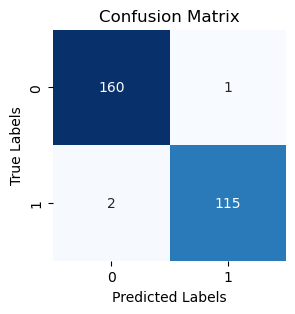

Precision: 0.99
Recall: 0.98
F1 score: 0.99
9/9 [==============================] - 1s 46ms/step


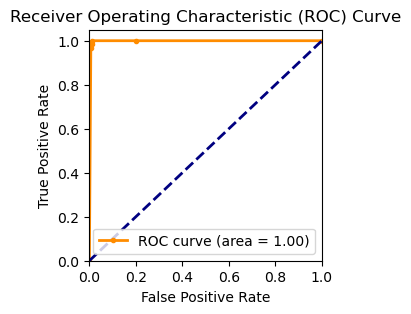

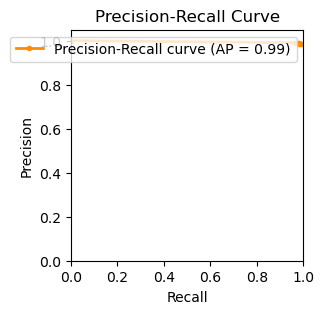

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Set the seed for reproducibility

#seed = 34
seed = 123

np.random.seed(seed)
tf.random.set_seed(seed)

# Define the directory where the dataset is stored
dataset_dir = 'E:/modified_dataset'

# Define the image size and channels
img_size = (224, 224)
img_channels = 3

# Define the number of notes in the dataset
num_notes = len(os.listdir(os.path.join(dataset_dir, 'real_notes'))) + len(os.listdir(os.path.join(dataset_dir, 'fake_notes'))) 

# Define the DenseNet121 model with pre-trained weights
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], img_channels))



def extract_features(dataset_dir, densenet_model):
    features_list = []
    labels_list = []
    note_paths_list = []
    
    counter = 1 
    
    for class_dir in os.listdir(dataset_dir):
        if class_dir.startswith('.'):
            continue
        class_path = os.path.join(dataset_dir, class_dir)

        for note_dir in os.listdir(class_path):
            if note_dir.startswith('.'):
                continue
            note_path = os.path.join(class_path, note_dir)

            num_images_per_note = len([name for name in os.listdir(note_path) if os.path.isfile(os.path.join(note_path, name))])
            images = []
            
            # Print the counter for the current image being processed
            print(f"Processing note {counter} ")
            counter += 1

            for i in range(1, num_images_per_note + 1):
                image_path = os.path.join(note_path, f'note_{note_dir.split("_")[1]}_{i}.jpg')

                image = cv2.imread(image_path)
                image = cv2.resize(image, img_size)
                image = preprocess_input(image)
                images.append(image)

            features = densenet_model.predict(np.array(images))
            
            features = features.reshape((1, num_images_per_note, 7, 7, 1024))
            
            features_list.append(features)
            if class_dir == 'real_notes':
                labels_list.append(0)
            else:
                labels_list.append(1)
            
            note_paths_list.append(note_path)
    
    X = np.vstack(features_list)
    y = np.array(labels_list)
    
    return X, y, note_paths_list

X, y, note_paths = extract_features(dataset_dir, densenet_model)

X_train, X_val_test, y_train, y_val_test, note_paths_train, note_paths_val_test = train_test_split(X, y, note_paths, test_size=0.4, random_state=seed)
X_val, X_test, y_val, y_test, note_paths_val, note_paths_test = train_test_split(X_val_test, y_val_test, note_paths_val_test, test_size=0.5, random_state=seed)

input_tensor = Input(shape=(X.shape[1], 7, 7, 1024))

split_tensors = Lambda(lambda x: tf.unstack(x, axis=1))(input_tensor)
branches = [Flatten()(split_tensors[i]) for i in range(X.shape[1])]
concat = Concatenate()(branches)

fcnn = Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(concat)  # Added L2 regularization
fcnn = Dense(1, activation='sigmoid')(fcnn)
model = Model(inputs=input_tensor, outputs=fcnn)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#Saving the best Model
# Define the directory where you want to save the best model
best_model_dir = 'E:/my_model'

# Create the directory if it does not exist
os.makedirs(best_model_dir, exist_ok=True)

# Define the ModelCheckpoint callback with the updated file path
best_model_file_path = os.path.join(best_model_dir, 'denseNet121_model.h5')
checkpoint = ModelCheckpoint(best_model_file_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])
# Import the necessary libraries
import matplotlib.pyplot as plt

# Plot the training and validation accuracy vs epoch
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (Train and Validation) vs Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss vs epoch
fig, ax = plt.subplots(figsize=(5,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Train and Validation) vs Epoch')
plt.legend(loc='upper right')
plt.show()

# Load the best model saved by ModelCheckpoint
best_model = tf.keras.models.load_model(best_model_file_path)

test_loss, test_acc = best_model.evaluate(X_test, y_test)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")



# Evaluate the best model on the validation set
val_loss, val_acc = best_model.evaluate(X_val, y_val)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_acc}")




# Get the predicted labels
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)


# Function to convert numerical labels to string labels
def label_to_string(label):
    return "real" if label == 0 else "fake"

# Print the original labels, predicted labels, and note_paths for the test set
print("\n Note Path | Predicted Label | Original Label ")
print("-" * 45)
for original_label, predicted_label, note_path in zip(y_test, predicted_labels.flatten(), note_paths_test):
    print(f" {note_path} | {label_to_string(predicted_label)} | {label_to_string(original_label)}")

# Import the necessary libraries
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, ax=ax , fmt='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()



# Calculate and print precision, recall, and F1 score
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

from sklearn.metrics import roc_curve, auc

# Make predictions using the best model and get probabilities
y_pred_probs = best_model.predict(X_test)

# Calculate the FPR, TPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, marker='o', markersize=3 , label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()





from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision, recall, and threshold values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Calculate the average precision
average_precision = average_precision_score(y_test, y_pred_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(3, 3))
plt.plot(recall, precision, color='darkorange', lw=2,marker='o', markersize=3, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()







In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model

def predict_note_type(model, note_path):
    img_size = (224, 224)
    img_channels = 3
    densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], img_channels))
    note_images = []
    for i in range(1, 7):
        image_path = os.path.join(note_path, f'{note_path.split("/")[-1]}_{i}.jpg')
        print(f"Loading image: {image_path}")
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
        note_images.append(image)
    
    preprocessed_images = []
    for image in note_images:
        image = cv2.resize(image, img_size)
        image = preprocess_input(image)
        image_features = densenet_model.predict(np.expand_dims(image, axis=0))
        preprocessed_images.append(image_features.reshape((1, 7, 7, 1024)))
    
    X_features = np.concatenate(preprocessed_images, axis=0)
    X_features = X_features.reshape((1, 6, 7, 7, 1024))

    # Make predictions on the input images
    y_pred = model.predict(X_features)
    y_pred_binary = (y_pred > 0.5).astype(int)
    return y_pred_binary[0][0]

note_path = 'E:/modified_dataset/real_notes/note_101'


model = load_model('E:/my_model/denseNet121_model.h5')
#model.summary()
result = predict_note_type(model, note_path)
if result == 0:
    print("Your note is real")
else:
    print("Your note is fake")


Loading image: E:/modified_dataset/real_notes/note_101\note_101_1.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_2.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_3.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_4.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_5.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_6.jpg
1/1 [==============================] - 0s 182ms/step
Your note is real


In [2]:
model = load_model('E:/my_model/denseNet121_model.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 7, 7, 10  0           []                               
                                24)]                                                              
                                                                                                  
 lambda (Lambda)                [(None, 7, 7, 1024)  0           ['input_2[0][0]']                
                                , (None, 7, 7, 1024                                               
                                ),                                                                
                                 (None, 7, 7, 1024)                                               
                                , (None, 7, 7, 1024                                           

In [1]:
import os
import cv2
import numpy as np
import time
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import DenseNet121

def predict_note_type(model, note_path):
    img_size = (224, 224)
    img_channels = 3

    densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], img_channels))
    note_images = []
    for i in range(1, 7):
        image_path = os.path.join(note_path, f'{note_path.split("/")[-1]}_{i}.jpg')
        print(f"Loading image: {image_path}")
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
        # Resize the image to the desired size
        image = cv2.resize(image, img_size)
        note_images.append(image)

    # Create a collage of two rows, each having three images
    collage_top = np.hstack(note_images[:3])
    collage_bottom = np.hstack(note_images[3:])
    collage = np.vstack([collage_top, collage_bottom])

    preprocessed_images = []
    for image in note_images:
        image = preprocess_input(image)
        image_features = densenet_model.predict(np.expand_dims(image, axis=0))
        preprocessed_images.append(image_features.reshape((1, 7, 7, 1024)))  # DenseNet121 has 1024 filters

    X_features = np.concatenate(preprocessed_images, axis=0)
    X_features = X_features.reshape((1, 6, 7, 7, 1024))

    # Load the saved model

    # Make predictions on the input images and calculate inference time
    start_time = time.time()
    y_pred = model.predict(X_features)
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds

    y_pred_binary = (y_pred > 0.5).astype(int)
    return y_pred_binary[0][0], collage, inference_time

note_path = 'E:/modified_dataset/real_notes/note_101'

model = load_model('E:/my_model/denseNet121_model.h5')
result, collage, inference_time = predict_note_type(model, note_path)

# Determine the text color (red for fake, green for real)
text_color = (0, 0, 255) if result == 1 else (0, 255, 0)

# Get the size of the collage
height, width, _ = collage.shape

# Get the size of the result text
result_text = "Your note is fake" if result == 1 else "Your note is real"
(result_font_width, result_font_height), _ = cv2.getTextSize(result_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)

# Get the size of the inference time text
inference_time_text = f"Inference Time: {inference_time:.2f} ms"
(inference_font_width, inference_font_height), _ = cv2.getTextSize(inference_time_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)

# Calculate the position to center the texts
result_text_x = int((width - result_font_width) / 2)
result_text_y = int(height / 2) - int((result_font_height + inference_font_height) / 2)
inference_text_x = int((width - inference_font_width) / 2)
inference_text_y = int(height / 2) + int((result_font_height + inference_font_height) / 2)

# Display the texts on the collage
cv2.putText(collage, result_text, (result_text_x, result_text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 3)
cv2.putText(collage, inference_time_text, (inference_text_x, inference_text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 3)

# Display the collage
cv2.imshow("Note Collage", collage)
cv2.waitKey(0)
cv2.destroyAllWindows()



Loading image: E:/modified_dataset/real_notes/note_101\note_101_1.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_2.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_3.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_4.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_5.jpg
Loading image: E:/modified_dataset/real_notes/note_101\note_101_6.jpg
1/1 [==============================] - 0s 178ms/step
